<font face="Calibri" color="darkgreen" size=10>Non-Parametric Methods</font>

## <font face="Garamond" color="blue" size=6>The Nadaraya-Watson Regressor</font>


<font color='red'>**Main Idea**: Estimate a conditional mean (expected value).</font>

$$\large{
\mathbb{E}[Y| X=x]=\sum\limits_{i=1}^nW_{i}(x)y_i}
$$

If we have estimates for the joint probability density $f$ and the marginal density $f_X$ we consider:

$$\large{
m(x)=\mathbb{E}[y| X=x]=\int y f_{Y| X=x}(y)\,\mathrm{d}y=\frac{\int yf(x,y)\,\mathrm{d}y}{f_X(x)}\tag{1}
}
$$

where $X$ is the input data (features) and $Y$ is the dependent variable.

We approximate the joint probability density function by using a kernel:

$$\large{
\begin{align}
\hat{f}(x,y;\mathbf{h})=\frac{1}{n}\sum_{i=1}^n K_{h_1}(x-x_{i})K_{h_2}(y-y_{i}).
\end{align}}
$$

The marginal density is also approximated in a similar way:

$$\large{
\hat{f}_X(x;h_1)=\frac{1}{n}\sum_{i=1}^nK_{h_1}(x-x_{i})}.
$$

By substituting these approximations into equation (1) we obtain:

$${
\begin{align*}
\frac{\int y \hat{f}(x,y;\mathbf{h})\,\mathrm{d}y}{\hat{f}_X(x;h_1)}=&\,\frac{\int y \frac{1}{n}\sum_{i=1}^nK_{h_1}(x-X_i)K_{h_2}(y-y_i)\,\mathrm{d}y}{\frac{1}{n}\sum_{i=1}^nK_{h_1}(x-x_i)}\\
=&\,\frac{\frac{1}{n}\sum_{i=1}^nK_{h_1}(x-x_i)\int y K_{h_2}(y-y_i)\,\mathrm{d}y}{\frac{1}{n}\sum_{i=1}^nK_{h_1}(x-x_i)}\\
=&\,\frac{\frac{1}{n}\sum_{i=1}^nK_{h_1}(x-x_i)y_i}{\frac{1}{n}\sum_{i=1}^nK_{h_1}(x-x_i)}\\
=&\,\sum_{i=1}^n\frac{K_{h_1}(x-x_i)}{\sum_{i=1}^nK_{h_1}(x-x_i)}y_i.
\end{align*}}
$$

Thus the conditional mean $\mathbb{E}[Y| X=x]$ can be seen as a weighted average of $y_i$:

$$\large{
\mathbb{E}[Y| X=x]=\sum\limits_{i=1}^nW_{i}(x)y_i}
$$

where

$$\large{
\begin{align*}
W_{i}(x):=\frac{K_h(x-x_i)}{\sum_{i=1}^nK_h(x-x_i)}.
\end{align*}}
$$

That is to say that the Nadaraya-Watson estimator is a locally weighted mean of $y_i$ around $x.$

REFERENCES:
1. https://bookdown.org/egarpor/PM-UC3M/
2. https://www.stat.cmu.edu/~larry/=sml/NonparRegression.pdf


## Setup

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
# general imports
import time
import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as R2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV,train_test_split as tts
from sklearn.datasets import make_spd_matrix
from scipy.interpolate import interp1d
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import pyplot

In [3]:
# here we import the N-W regressor from the provided class
from nadaraya_watson import NadarayaWatson, NadarayaWatsonCV

## Example with Data Simulation

In [14]:
rng = np.random.RandomState(1234)

# #############################################################################
# Generate sample data
X = 10 * rng.rand(100, 1)
y = 2*np.cos(-X**2/9).ravel()

# Add noise to targets
#y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))

y = y + 0.5*np.random.normal(0,1,len(X))

X_plot = np.linspace(0, 10, 1000)[:, None]

# #############################################################################

GridSearchCV k fold cross validation fitted in 0.29 s
	optimal bandwidth found: 23.10
NadarayaWatsonCV leave-one-out cross validation fitted in 0.01 s
	optimal bandwidth found: 23.101


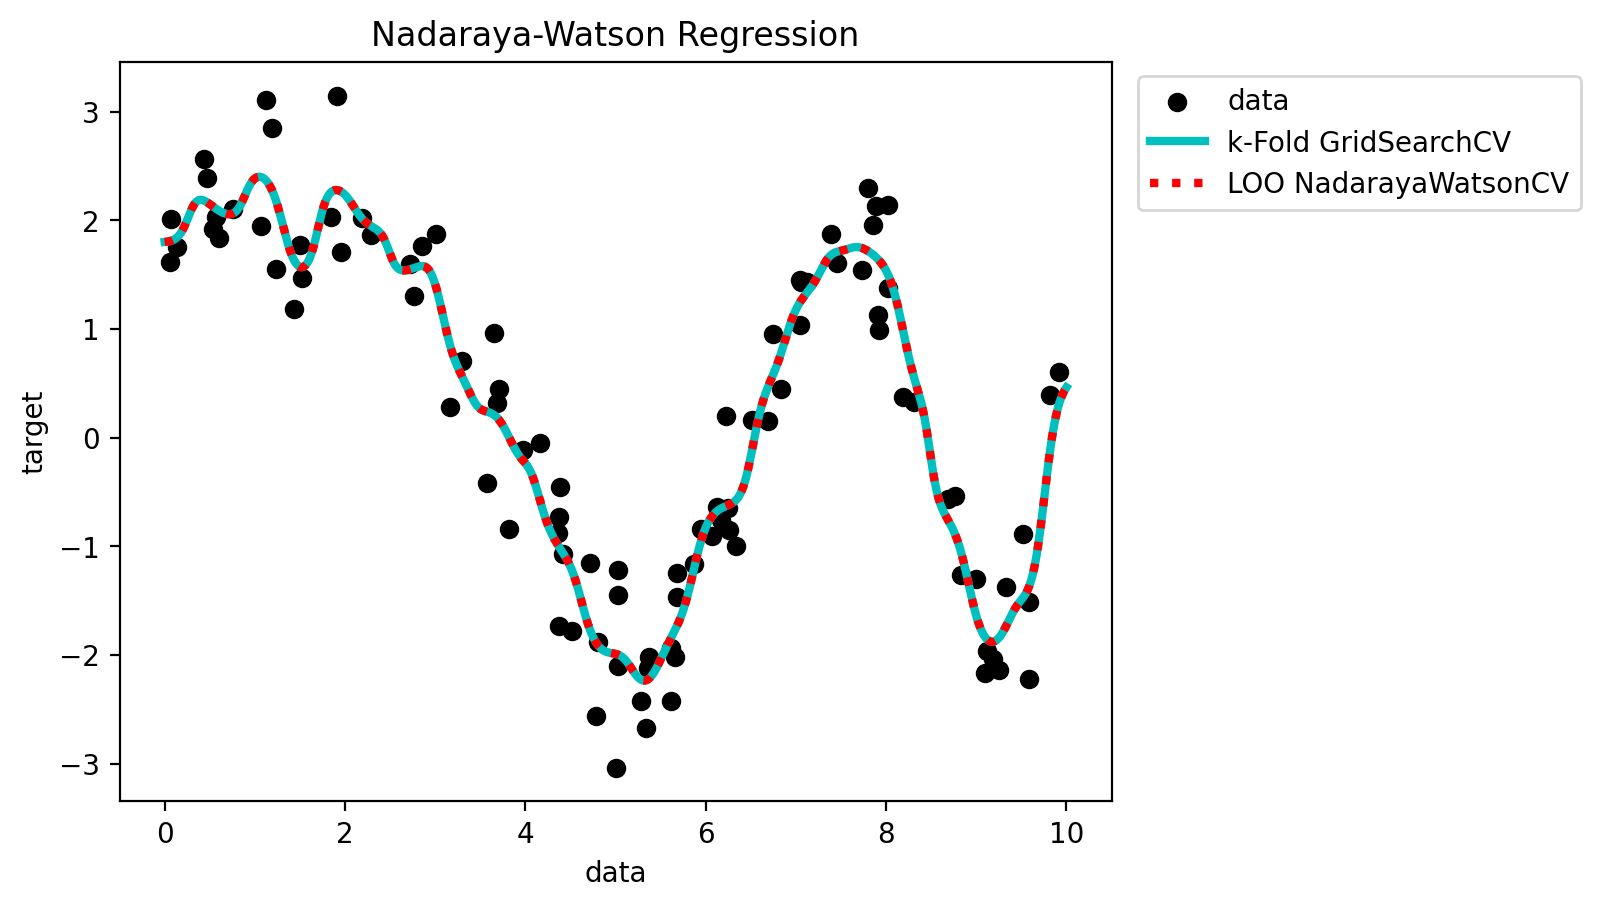

In [15]:
# Fit regression model
train_size = 100
param_grid=[dict(kernel=['polynomial'], degree=np.arange(1, 5)),dict(kernel=['rbf'], gamma=np.logspace(-5, 5, 100))]

# use the sklearn gridsearch
nw_gs = GridSearchCV(NadarayaWatson(), cv=10, param_grid=param_grid)

# use the internal LOO (leave-one-out cross-validation)
nw_cv = NadarayaWatsonCV(param_grid)

# fit k-fold using GridSearch
t0 = time.time()
nw_gs.fit(X[:train_size], y[:train_size])
gs_fit = time.time() - t0
print("GridSearchCV k fold cross validation fitted in %.2f s" % gs_fit)
print("\toptimal bandwidth found: %.2f" % nw_gs.best_estimator_.gamma)

# fit leave-one-out using NadarayaWatsonCV
t0 = time.time()
nw_cv.fit(X[:train_size], y[:train_size])
cv_fit = time.time() - t0
print("NadarayaWatsonCV leave-one-out cross validation fitted in %.2f s" % cv_fit)
print("\toptimal bandwidth found: %.3f" % nw_cv.gamma)

# predict
y_gs = nw_gs.predict(X_plot)
y_cv = nw_cv.predict(X_plot)

plt.scatter(X[:100], y[:100], c='k', label='data', zorder=1,
            edgecolors=(0, 0, 0))
plt.plot(X_plot, y_gs, 'c-', lw=3, label='k-Fold GridSearchCV')
plt.plot(X_plot, y_cv, 'r:', lw=3, label='LOO NadarayaWatsonCV')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Nadaraya-Watson Regression')
plt.legend(loc = 9, bbox_to_anchor=(1.25,1))
#plt.savefig('fig3.png',bbox_inches='tight',dpi=300)
plt.show()

# Real Data Application of Kernel Regression (Nadaraya-Watson)

In [6]:
df = pd.read_csv('../Data Sets/housing.csv')
features = ['crime','rooms','residential','industrial','nox','older','distance','highway','tax','ptratio','lstat']
X = np.array(df[features])
y = np.array(df['cmedv']).reshape(-1,1)
Xdf = df[features]

In [7]:
param = dict(kernel=["laplacian"],gamma=np.logspace(-5, 5, 1000))
model = NadarayaWatsonCV(param_grid,scoring='neg_mean_absolute_error')
model.fit(Xdf, y)

NadarayaWatsonCV(gamma=0.04328761281083057, kernel='rbf',
                 param_grid=[{'degree': array([1, 2, 3, 4]),
                              'kernel': ['polynomial']},
                             {'gamma': array([1.00000000e-05, 1.26185688e-05, 1.59228279e-05, 2.00923300e-05,
       2.53536449e-05, 3.19926714e-05, 4.03701726e-05, 5.09413801e-05,
       6.42807312e-05, 8.11130831e-05, 1.02353102e-04, 1.29154967e-04,
       1.62975083e-04, 2.05651231e-04, 2.59...
       1.20450354e+03, 1.51991108e+03, 1.91791026e+03, 2.42012826e+03,
       3.05385551e+03, 3.85352859e+03, 4.86260158e+03, 6.13590727e+03,
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.12571585e+04, 3.94420606e+04,
       4.97702356e+04, 6.28029144e+04, 7.92482898e+04, 1.00000000e+05]),
                              'kernel': ['rbf']}],
                 scoring='neg_mean_absolute_error')

In [8]:
model.score(Xdf,y)

0.9246714480015166

In [ ]:
yhat = model.predict(Xdf)

In [9]:
def DoKFold_NW(X,y,k):
  PS = []
  kf = KFold(n_splits=k,shuffle=True,random_state=1234)
  param_grid=dict(kernel=["laplacian"],gamma=np.logspace(-1, 1, 100))
  model = NadarayaWatsonCV(param_grid,scoring='neg_mean_absolute_error')
  for idxtrain, idxtest in kf.split(X):
    X_train = X[idxtrain,:]
    y_train = y[idxtrain]
    X_test  = X[idxtest,:]
    y_test  = y[idxtest]
    model.fit(X_train,y_train)
    yhat_test = model.predict(X_test)
    PS.append(R2(y_test,yhat_test))
  return np.mean(PS)

In [28]:
DoKFold_NW(Xdf.values,y,10)

0.6502930910016382